# Can we represent spectral lines with sparse tensors in PyTorch?

April 23-26, 2021   
Updated December 2021


gully


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from torch import nn
from tqdm import trange
import torch.optim as optim
import torch.profiler
from blase.emulator import PhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
active_lower, active_upper = 8079, 12785
line_threshold_lower, line_threshold_upper = 8049, 12815

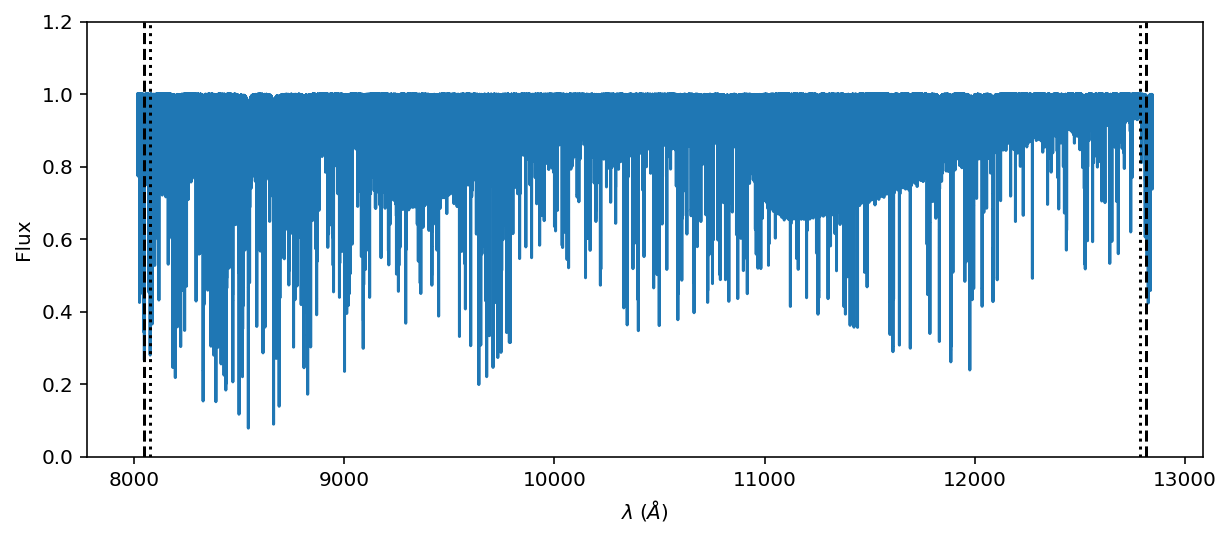

In [6]:
ax = spectrum.plot(ylo=0);
ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k')

In [7]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [8]:
# Create the emulator
emulator = PhoenixEmulator(wl_native, flux_native, prominence=0.02)
emulator.to(device)

PhoenixEmulator()

In [9]:
wl_0 = emulator.lam_centers.detach().numpy()

In [10]:
mask = (wl_0 > line_threshold_lower) & (wl_0 < line_threshold_upper)
wl_0 = wl_0[mask]

In [11]:
amplitudes = np.exp(emulator.amplitudes.detach().numpy()[mask])

In [12]:
amplitudes

array([0.00585902, 0.01674006, 0.10288782, ..., 0.05486622, 0.03304236,
       0.04595865])

In [13]:
widths = np.exp(emulator.sigma_widths.detach().numpy()[mask])

In [14]:
widths

array([0.03142242, 0.03226613, 0.05065724, ..., 0.05868538, 0.05510838,
       0.04888698])

In [15]:
wl_0.shape

(6489,)

You can't run the line below because it would max out the CPU and GPU RAM:

```python
with torch.no_grad():
    synthetic = emulator.forward(torch.tensor(wl_native))
```

Instead, we either break it into minibatches, or we use a *sparse* implementation.

## Sparse implementation

We need to define a **wing cut** around each spectral line.  Let's assume 30 Å.

In [16]:
from tqdm.notebook import tqdm

In [17]:
n_pix = len(wl_native)

In [18]:
n_lines = len(wl_0)

In [19]:
n_pix, n_lines

(340349, 6489)

In [20]:
pixel_indices = np.arange(n_pix, dtype=int)

In [21]:
wing_cut_angstroms = 30

In [22]:
wing_cut_pixels = 6000

In [23]:
list_of_nonzero_indices = []
for line_center in tqdm(wl_0):
    distance = np.abs(wl_native - line_center)
    these_pixels = np.argsort(distance)[0:wing_cut_pixels]
    list_of_nonzero_indices.append(sorted(these_pixels))

  0%|          | 0/6489 [00:00<?, ?it/s]

In [24]:
indices_2D = np.array(list_of_nonzero_indices)

In [25]:
indices_1D = indices_2D.reshape(-1)

In [26]:
indices_2D.shape, indices_1D.shape

((6489, 6000), (38934000,))

In [27]:
n_pix / wing_cut_pixels

56.724833333333336

With sparsity we should get about a 50x speedup, not to mention memory savings.

In [28]:
wl_2D = wl_native[indices_2D]

In [29]:
def log_gaussian(wl, amplitudes, lam_centers, sigmas):
    """Compute Gaussian assuming sparse 2D implementation"""
    return np.log(amplitudes) + (-0.5 * (wl-lam_centers)**2 / sigmas**2)

In [30]:
ln_flux_2D = log_gaussian(wl_2D, 
                   amplitudes[:, np.newaxis],
                   wl_0[:, np.newaxis],
                   widths[:, np.newaxis])

In [31]:
wl_1D, ln_flux_1D = wl_2D.reshape(-1), ln_flux_2D.reshape(-1)

In [32]:
sparse_matrix = torch.sparse_coo_tensor(indices_1D[np.newaxis, :], np.log(1-np.exp(ln_flux_1D)), size=(n_pix,) )

In [33]:
result_1D = sparse_matrix.to_dense()

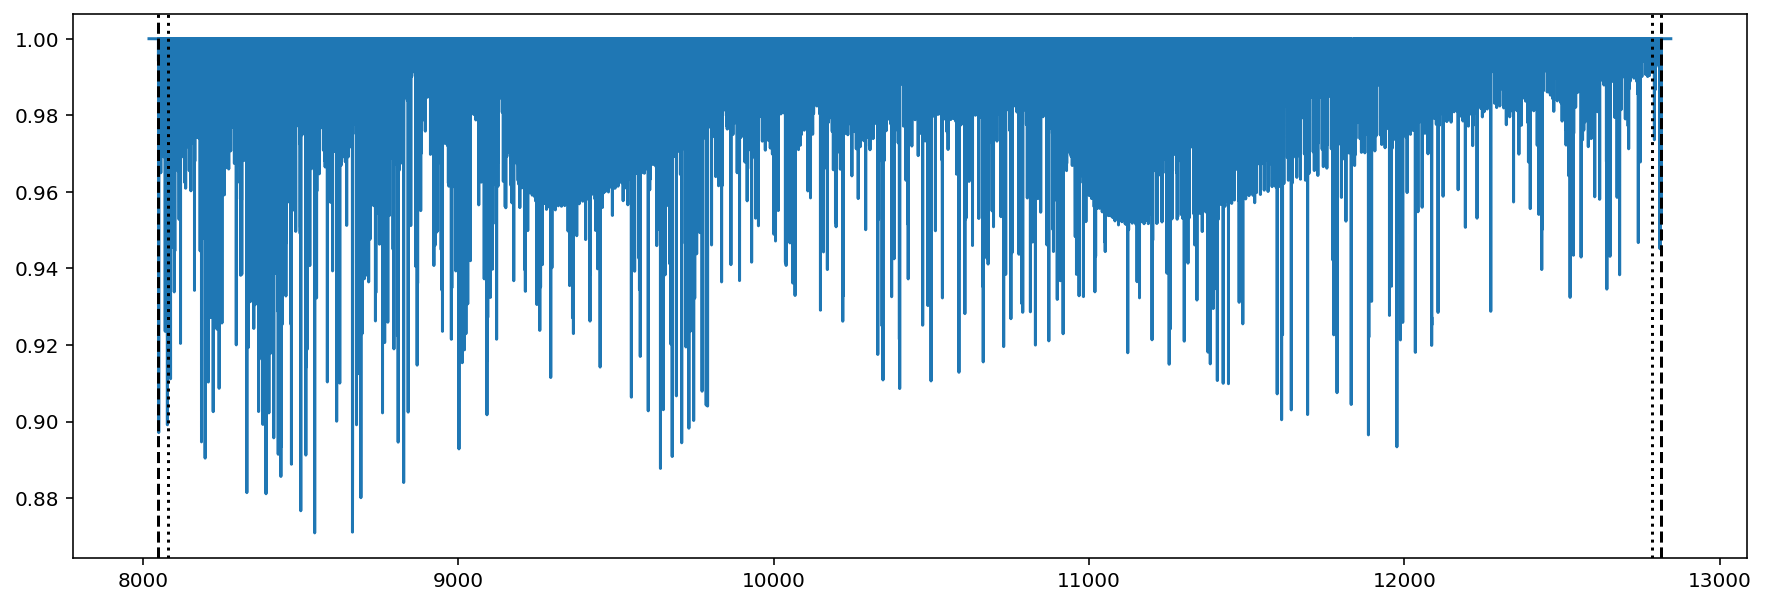

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(wl_native, np.exp(result_1D))

ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k');

Looks good!  We have a sketch of a sparse implementation.